In [1]:
import math as math
import ROOT as r
import matplotlib.pyplot as plt
import numpy as np
import csv
import lmfit
from scipy import interpolate
from scipy import stats
from lmfit import Minimizer, Parameters
from lmfit.lineshapes import gaussian
from lmfit.printfuncs import report_fit
from ROOT import std,RooDataHist
from array import array
import csv

Welcome to JupyROOT 6.20/04


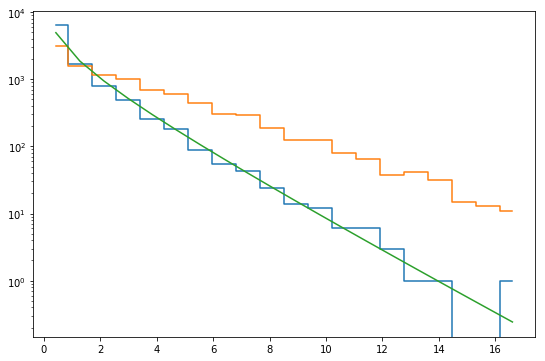

In [32]:
#Now lets do this whole procedure but with fitting so you know how it goes
def fitGauslikelihood(isample,mu0=-1,sigma0=-1):
    #I am going to use ROOT, I am sorry about this, but it makes it easy for me
    #Make a histogram centered about 0
    lH=r.TH1F("tmp","tmp",20,-10,10)
    for pSample in isample:
        lH.Fill(pSample)
    f1 = r.TF1("test","gaus",-10,10)
    f1.SetParameter(0,len(isample))
    f1.SetParameter(1,isample.mean())
    f1.SetParameter(2,isample.std())
    if mu0 != -1:
        f1.FixParameter(1,mu0)
    if sigma0 != -1:
        f1.FixParameter(2,sigma0)
    result=lH.Fit("test","B S L Q")
    #result.Print()
    #print(mu0,result.MinFcnValue())
    return result.MinFcnValue()

ntoys=10000
deltaLL1=[]
for i0 in range(ntoys):
    testsamples1 = np.random.normal(0.,1, 50)
    hypoth=fitGauslikelihood(testsamples1,0)
    null  =fitGauslikelihood(testsamples1)
    val=hypoth-null
    #print(val,hypoth,null)
    deltaLL1.append(2*val)

deltaLL2=[]
for i0 in range(ntoys):
    testsamples1 = np.random.normal(0.2,1, 50)
    hypoth=fitGauslikelihood(testsamples1,0)
    null  =fitGauslikelihood(testsamples1)
    val=abs(hypoth-null)
    deltaLL2.append(2*val)

    
from scipy.special import erf
y1, bin_edges = np.histogram(deltaLL1, bins=20)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
chi2 = []
for x in bin_centers:#range(len(bin_centers)):
    chi2val=stats.chi2.pdf(x, 1)
    #chi2val= erf(np.sqrt(bin_edges[x+1]))-erf(np.sqrt(bin_edges[x]))
    chi2.append(len(deltaLL1)*chi2val)

y2, bin_edges = np.histogram(deltaLL2, bins=bin_edges)
fig, ax = plt.subplots(figsize=(9,6))
plt.plot(bin_centers,y1,drawstyle = 'steps-mid')
plt.plot(bin_centers,y2,drawstyle = 'steps-mid')
#plt.style.use('fast')
#plt.errorbar(bin_centers,y1/ntoys,yerr=y1**0.5/ntoys,marker='.',drawstyle = 'steps-mid')
#plt.errorbar(bin_centers,y2/ntoys,yerr=y2**0.5/ntoys,marker='.',drawstyle = 'steps-mid')
plt.plot(bin_centers,chi2)
ax.set_yscale('log')
plt.show()

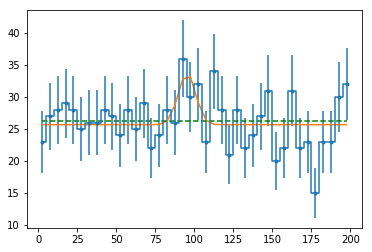

('Delta LL', 4.130698261356553)
('Delta LL 1-Fixed:', 3.400517719754504)
('Delta LL 2-Fixed:', 3.3798963688069072)
 FCN=10.9116 FROM MIGRAD    STATUS=CONVERGED     138 CALLS         139 TOTAL
                     EDM=4.41448e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.09596e+00   5.29493e+00   9.44996e-03  -1.24670e-05
   2  p1           9.52688e+01   3.95675e+00   8.79408e-03  -3.80191e-06
   3  p2          -5.52533e+00   4.45749e+00   7.49614e-03  -3.79933e-05
   4  p3           2.56894e+01   8.76661e-01   1.88651e-03   7.98395e-05
                               ERR DEF= 0.5
 FCN=12.977 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=5.39803e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VA

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).


In [2]:
#Now that we have gotten everything to match, lets now go one step further and do something more complciated
#Lets try to find a bump on a flat background
#What we need to do is run two fits one with a signal and background, and one with only background 

#First lets make a data sample and fit it
bkg = np.random.uniform(0,200, 1000)
sig = np.random.normal (100,15,50)
data = np.append(sig,bkg)

#Annoying conversion functions
def convertHistToArr(iH):
    bin_centers=[]
    bin_content=[]
    bin_error=[]
    for i0 in range(iH.GetNbinsX()):
        pX=iH.GetBinCenter(i0+1)
        pY=iH.GetBinContent(i0+1)
        pYErr=iH.GetBinError(i0+1)
        bin_centers.append(pX)
        bin_content.append(pY)
        bin_error  .append(pYErr)
    return bin_content, bin_centers, bin_error

#we will use root to fit this again
def fitSigBkg(isample,iFix1=False,iFix2=False):
    #Signal+Background hypothesis: A guassian + a constant
    sb = r.TF1("sb","[0] * exp(-(x-[1])*(x-[1])/2./[2]/[2])+[3]",0,200)
    sb.SetParameter(0,len(isample)*1./math.sqrt(2.*math.pi*400))
    sb.SetParameter(1,100)
    sb.SetParameter(2,15)
    sb.SetParameter(3,30)
    if iFix1:
        sb.FixParameter(1,100)
    if iFix2:
        sb.FixParameter(2,15)    
    #Background hypothesis: A guassian + a constant
    b  = r.TF1("b","[0]",0,200)

    #Fill and Fit
    lH=r.TH1F("tmp","tmp",40,0,200)
    for pSample in isample:
        lH.Fill(pSample)
    lH.Sumw2()
    lSB=lH.Fit("sb","B S L")
    lB=lH.Fit("b","B S L")
    pVal=-2*(lSB.MinFcnValue()-lB.MinFcnValue())
    return lH,sb,b,pVal

lH,sb,b,NLL = fitSigBkg(data)
y,bins,yerr=convertHistToArr(lH)
fs=[]
fb=[]
for x in bins:
    val=sb.Eval(x)
    fs.append(val)
    val=b.Eval(x)
    fb.append(val)
plt.errorbar(bins,y,yerr=yerr,marker='.',drawstyle = 'steps-mid')
plt.plot    (bins,fs)
plt.plot    (bins,fb,"g--")
plt.show()
#Lets compute Delta Likelihood
print("Delta LL",NLL)
#
lH,sb,b,NLL1 = fitSigBkg(data,False,True)
lH,sb,b,NLL2 = fitSigBkg(data,True,True)
print("Delta LL 1-Fixed:",NLL1)
print("Delta LL 2-Fixed:",NLL2)


('Significance with 3 floating', 0.97075671389969)
('Significance with 2 floating', 0.9729005180438605)
('Significance with 1 floating', 0.9896018113938743)


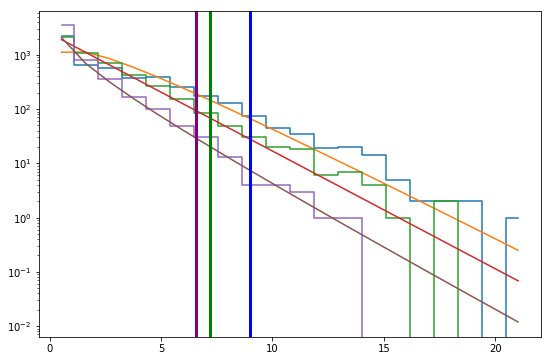

In [93]:
#Now lets see how delta likelihood would work in this case
#First lets make a data sample and fit it
#we will use root to fit this again
def fitSigBkgLike(isample,iFix1=False,iFix2=False):
    #Signal+Background hypothesis: A guassian + a constant
    sb = r.TF1("sb","[0] * exp(-(x-[1])*(x-[1])/2./[2]/[2])+[3]",0,200)
    sb.SetParameter(0,len(isample)*1./math.sqrt(2.*math.pi*400))
    sb.SetParameter(1,100)
    sb.SetParameter(2,15)
    sb.SetParameter(3,30)
    if iFix1:
        sb.FixParameter(1,100)
    if iFix2:
        sb.FixParameter(2,15)
    #Background hypothesis: A guassian + a constant
    b  = r.TF1("b","[0]",0,200)
    #Fill and Fit
    lH=r.TH1F("tmp","tmp",40,0,200)
    for pSample in isample:
        lH.Fill(pSample)
    lH.Sumw2()
    lSB=lH.Fit("sb","B S Q L")
    lB=lH.Fit("b","B S Q L")
    pVal=-2*(lSB.MinFcnValue()-lB.MinFcnValue())
    if pVal < 0:
        pVal=0
    return pVal

ntoys=5000
deltaLL1=[]
deltaLL2=[]
deltaLL3=[]
for i0 in range(ntoys):
    toybkg = np.random.uniform(0,200, 1000)
    deltall = fitSigBkgLike(toybkg)
    deltaLL1.append(deltall)
    deltall = fitSigBkgLike(toybkg,False,True)
    deltaLL2.append(deltall)
    deltall = fitSigBkgLike(toybkg,True,True)
    deltaLL3.append(deltall)

    
y1, bin_edges = np.histogram(deltaLL1, bins=20)
y2, bin_edges = np.histogram(deltaLL2, bins=bin_edges)
y3, bin_edges = np.histogram(deltaLL3, bins=bin_edges)
fig, ax = plt.subplots(figsize=(9,6))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
chi21 = []
chi22 = []
chi23 = []
for x in bin_centers:#range(len(bin_centers)):
    chi2val=stats.chi2.pdf(x, 3)
    chi21.append(len(deltaLL1)*chi2val)
    chi2val=stats.chi2.pdf(x, 2)
    chi22.append(len(deltaLL2)*chi2val)
    chi2val=stats.chi2.pdf(x, 1)
    chi23.append(len(deltaLL3)*chi2val)


plt.plot(bin_centers,y1,drawstyle = 'steps-mid')
plt.plot(bin_centers,chi21)
plt.plot(bin_centers,y2,drawstyle = 'steps-mid')
plt.plot(bin_centers,chi22)
plt.plot(bin_centers,y3,drawstyle = 'steps-mid')
plt.plot(bin_centers,chi23)
ax.axvline(x=NLL,linewidth=3,c='b')
ax.axvline(x=NLL1,linewidth=3,c='g')
ax.axvline(x=NLL2,linewidth=3,c='purple')
print("Significance with 3 floating",stats.chi2.cdf(NLL,3))
print("Significance with 2 floating",stats.chi2.cdf(NLL1,2))
print("Significance with 1 floating",stats.chi2.cdf(NLL2,1))
ax.set_yscale('log')
plt.show()

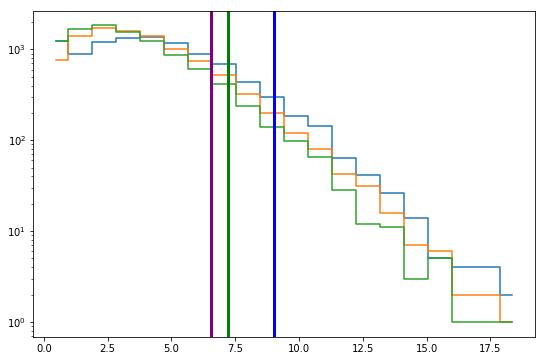

In [92]:
#Now how typical is this signal given the signal hypothesis
ntoys=10000
deltaLL1=[]
deltaLL2=[]
deltaLL3=[]
for i0 in range(ntoys):
    toybkg  = np.random.uniform(0,200, 1000)
    toysig  = np.random.normal (100,15,50)
    toydata = np.append(toysig,toybkg)
    deltall = fitSigBkgLike(toydata)
    deltaLL1.append(deltall)
    deltall = fitSigBkgLike(toydata,False,True)
    deltaLL2.append(deltall)
    deltall = fitSigBkgLike(toydata,True,True)
    deltaLL3.append(deltall)

y1, bin_edges = np.histogram(deltaLL1, bins=20)
y2, bin_edges = np.histogram(deltaLL2, bins=bin_edges)
y3, bin_edges = np.histogram(deltaLL3, bins=bin_edges)

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(bin_centers,y1,drawstyle = 'steps-mid')
plt.plot(bin_centers,y2,drawstyle = 'steps-mid')
plt.plot(bin_centers,y3,drawstyle = 'steps-mid')
ax.axvline(x=NLL,linewidth=3,c='b')
ax.axvline(x=NLL1,linewidth=3,c='g')
ax.axvline(x=NLL2,linewidth=3,c='purple')
ax.set_yscale('log')
plt.show()

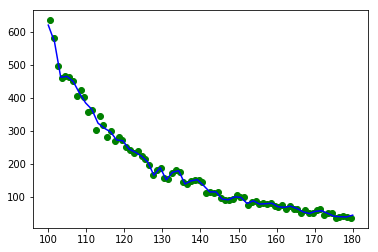

In [14]:
#ok now that we have all our tools at hand Lets do something real
#Lets look at some data and try to understan it as a function
from scipy import interpolate
import csv
x = []
y = []
y_err = []
label='out_2011.txt'
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=' ')
    for row in plots:
        x.append(float(row[1]))
        y.append(float(row[2]))
        #add poisson uncertainties                                                                                                 
        y_err.append(math.sqrt(float(row[2])))

tck = interpolate.splrep(x, y)
x2 = np.linspace(100, 180)
y2 = interpolate.splev(x2, tck)
plt.plot(x, y, 'go')
plt.plot(x2, y2, 'b')
#this gives us a function that we can play with




ValueError: x and y must have same first dimension, but have shapes (37,) and (40,)

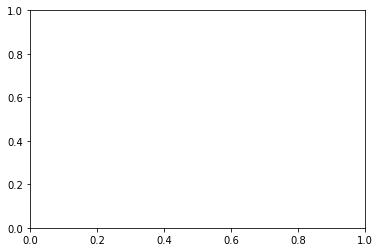

In [42]:
#Now lets do a convolution by hand
#Now lets do a convolution by hand
def splineconvolve(tck,f2,x,iMin=-15,iMax=15,iN=500):
    step=float((iMax-iMin))/float(iN)
    pInt=0
    for i0 in range(iN):
            pX   = i0*step+iMin
            pVal = interpolate.splev(x-pX,tck)*f2(pX)
            pInt += pVal*step
    return pInt

#Lets convolve our interpolated distribution with a gaussian
#Now define the gaussian
def gaussian(x,mean=0,sigma=1):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 

def gaussianpol(x,mean=2,sigma=1,a0=0.0,a1=0.001,a2=0):
    #val=a0+a1*x+a2*x**2/2
    #norm=(30*a0+30**2/2*a1+30**3/3*a2)
    #val=val/norm
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 

fig, ax = plt.subplots()
x_in=np.linspace(110, 170, 10)
gaus_out=np.array(list(map(gaussian, x_in))) #gaussian(x_in)
conv_out=[]
for val in x_in:
    pConv_out=splineconvolve(tck,gaussianpol,val)
    conv_out.append(pConv_out)
    
plt.plot(x, y, 'go')
plt.plot(x2, y2, 'b')
plt.plot(x_in,conv_out,c='orange')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()
#Now we have a smooth distribution from a data driven region, and we can shift it by moving mean

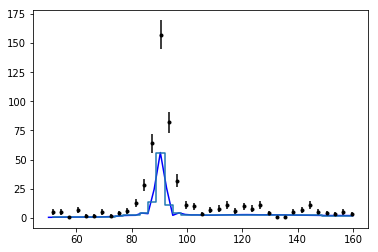

In [43]:
#Lets do a fit with a convolution in a way that we would actually use it
#Lets take some data and some simualtion and plot them
def load(ilabel):
    x=[]
    y=[]
    y_err=[]
    with open(ilabel,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=' ')
        print(plots)
        for row in plots:
            if float(row[1]) > 160:
                break
            x.append(float(row[1]))
            y.append(float(row[2]))
            #add poisson uncertainties                                                                                                 
            y_err.append(math.sqrt(float(row[2])))
    return x,y,y_err
x,y_data,y_err=load("data.txt")
x,y_mc,y_mc_err=load("zz_narrow.txt")

tck = interpolate.splrep(x, y_mc)
x2 = np.linspace(50, 160)
y2 = interpolate.splev(x2, tck)
plt.errorbar(x,y_data,yerr=y_err,marker='.',linestyle = 'None', color = 'black')
plt.plot(x2, y2, 'b')
plt.plot(x,y_mc,drawstyle = 'steps-mid')


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 37
    # variables        = 5
    chi-square         = 127.604211
    reduced chi-square = 3.98763160
    Akaike info crit   = 55.8065720
    Bayesian info crit = 63.8611616
##  Warning: uncertainties could not be estimated:
    sigma:     at initial value
[[Variables]]
    mean:      0.00000000 (init = 0)
    sigma:     1.00000000 (init = 1)
    sig:       3.31932976 (init = 2)
    baseline:  3.85307990 (init = 2)
    slope:    -0.05865384 (init = 0)


(<Figure size 432x432 with 2 Axes>,
 <matplotlib.gridspec.GridSpec at 0x140d4f110>)

<Figure size 432x288 with 0 Axes>

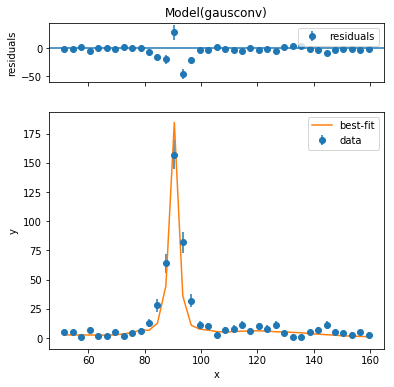

In [44]:
#now we can construct a fit with the histogram convolution, and a background function
def gaussian(x,mean=0,sigma=1):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 

def splineconvolvegaus(tck,f2,x,mean,sigma,iMin=-15,iMax=15,iN=500):
    step=float((iMax-iMin))/float(iN)
    pInt=0
    for i0 in range(iN):
            pX   = i0*step+iMin
            pVal = interpolate.splev(x-pX,tck)*f2(pX,mean,sigma)
            pInt += pVal*step
    return pInt

def gausconv(x,mean,sigma,sig,baseline,slope):
    val = interpolate.splev(x,tck)
    #val = splineconvolvegaus(tck,gaussian,x,mean,sigma)
    output = baseline+sig*val+slope*x
    return output

#hack to get the right uncertainties
weights = np.linspace(0.,len(y_data),num=len(y_data))
for i0 in range(len(y_data)):
    weights[i0] = float(1./y_err[i0])

model  = lmfit.Model(gausconv)
p = model.make_params(mean=0,sigma=1,sig=2,baseline=2,slope=0)
result = model.fit(data=y_data, params=p, x=x, weights=weights)
lmfit.report_fit(result)
plt.figure()
result.plot()



In [21]:
#now what if we to interpolate but with a more general generating function
#the new cool way to do this is with Guassian processes
#Lets give it a try
#load a gaussian process library (http://dfm.io/george/dev/tutorials/first/)
import george
from george import kernels
#kernel = np.var(y_data) * kernels.ExpSquaredKernel(0.5)
kernel = 2.0 * kernels.Matern32Kernel(5.0)
gp = george.GP(kernel)
gp.compute(x, y_err)

x_pred = np.linspace(40, 160, 100)
pred, pred_var = gp.predict(y_data, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.plot(x_pred, np.sin(x_pred), "--g")
pl.xlim(0, 10)
pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");


ImportError: No module named george

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.gridspec.GridSpec at 0x139565810>)

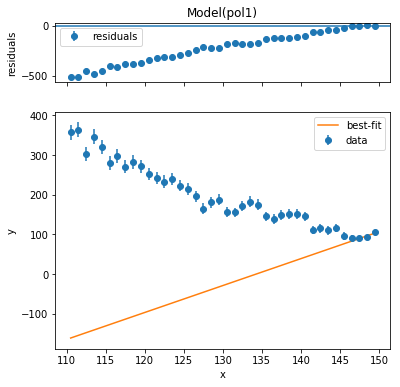

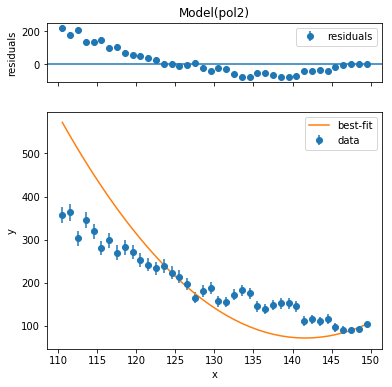

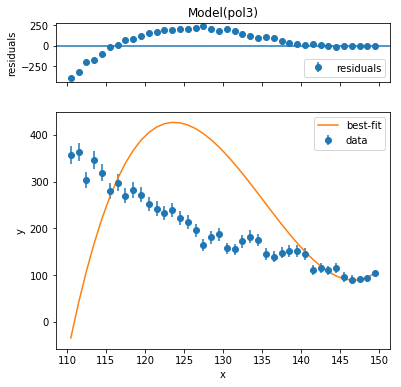

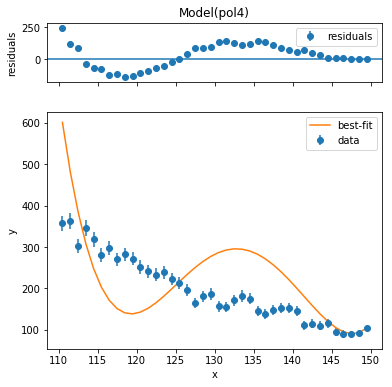

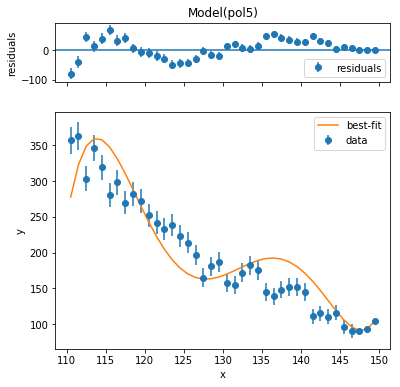

In [36]:
#Lets fit a bunch of polynomails with lmfit
x = []
y = []
y_err = []
label='out_2011.txt'
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=' ')
    for row in plots:
        if float(row[1]) > 150 or float(row[1]) < 110:
            continue
        x.append(float(row[1]))
        y.append(float(row[2]))
        #add poisson uncertainties                                                                                                 
        y_err.append(math.sqrt(float(row[2])))

weights = np.linspace(0.,len(y),num=len(y))
for i0 in range(len(y_data)):
    weights[i0] = float(1./y_err[i0])

#The question is what is it doing. Lets buid our own scheme to do this.
#we are going to generate functions with simple polynomials
#Lets fit our data with some polynomials
def pol1(x, p0, p1):
    pols=[p0,p1]
    y = np.polyval(pols,x)
    return y

def pol2(x, p0, p1,p2):
    pols=[p0,p1,p2]
    y = np.polyval(pols,x)
    return y

def pol3(x, p0, p1,p2,p3):
    pols=[p0,p1,p2,p3]
    y = np.polyval(pols,x)
    return y

def pol4(x, p0, p1,p2,p3,p4):
    pols=[p0,p1,p2,p3,p4]
    y = np.polyval(pols,x)
    return y

def pol5(x, p0, p1,p2,p3,p4,p5):
    pols=[p0,p1,p2,p3,p4,p5]
    y = np.polyval(pols,x)
    return y

#lets try them all
model1  = lmfit.Model(pol1)
p = model1.make_params(p0=0,p1=0)
result1 = model1.fit(data=y, params=p, x=x, weights=weights)

model2  = lmfit.Model(pol2)
p = model2.make_params(p0=0,p1=0,p2=0)
result2 = model2.fit(data=y, params=p, x=x, weights=weights)

model3  = lmfit.Model(pol3)
p = model3.make_params(p0=0,p1=0,p2=0,p3=0)
result3 = model3.fit(data=y, params=p, x=x, weights=weights)

model4  = lmfit.Model(pol4)
p = model4.make_params(p0=0,p1=0,p2=0,p3=0,p4=0)
result4 = model4.fit(data=y, params=p, x=x, weights=weights)

model5  = lmfit.Model(pol5)
p = model5.make_params(p0=0,p1=0,p2=0,p3=0,p4=0,p5=0)
result5 = model5.fit(data=y, params=p, x=x, weights=weights)

result1.plot()
result2.plot()
result3.plot()
result4.plot()
result5.plot()

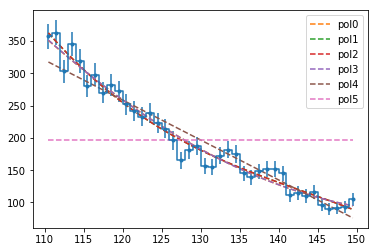

 FCN=21.584 FROM MIGRAD    STATUS=FAILED        313 CALLS         314 TOTAL
                     EDM=0.0196893    STRATEGY= 1      ERR MATRIX APPROXIMATE
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.48279e+03   9.80742e+01   6.65643e-03  -1.21164e-03
   2  p1          -2.47109e+01   1.25821e+00   4.93444e-05  -1.77901e-01
   3  p2           1.51478e-02   8.68174e-03   3.61247e-07  -2.95729e+01
   4  p3           3.26981e-04   6.21109e-05   2.61605e-09  -4.22612e+03
   5  p4          -1.38245e-10   4.29409e-07   1.87689e-11  -4.15211e+05
   6  p5          -1.67076e-09   1.98973e-09   1.33599e-13   3.96703e+06
                               ERR DEF= 0.5
 FCN=20.1539 FROM MIGRAD    STATUS=CONVERGED     277 CALLS         278 TOTAL
                     EDM=4.06167e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         

Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <Fit>: Abnormal termination of minimization.
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).


In [3]:
#Lets fit a bunch of polynomails with root
x = []
y = []
y_err = []
label='out_2011.txt'
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=' ')
    for row in plots:
        if float(row[1]) > 150 or float(row[1]) < 110:
            continue
        x.append(float(row[1]))
        y.append(float(row[2]))
        #add poisson uncertainties                                                                                                 
        y_err.append(math.sqrt(float(row[2])))

weights = np.linspace(0.,len(y),num=len(y))
for i0 in range(len(y)):
    weights[i0] = float(1./y_err[i0])

def fitSigBkgLike(ixsample,iysample,iFix=[0,0,0,0,0]):
    #Signal+Background hypothesis: A guassian + a constant
    b = r.TF1("b","pol5",110,150)
    b.SetParameter(0,iysample[0])
    b.SetParameter(1,0)
    b.SetParameter(2,0)
    b.SetParameter(3,0)
    b.SetParameter(4,0)
    b.SetParameter(5,0)
    if iFix[0]:
        b.FixParameter(1,0)
    if iFix[1]:
        b.FixParameter(2,0)
    if iFix[2]:
        b.FixParameter(3,0)
    if iFix[3]:
        b.FixParameter(4,0)
    if iFix[4]:
        b.FixParameter(5,0)
    #Fill and Fit
    lH=r.TH1F("tmp","tmp",40,110,150)
    for pSample in range(len(ixsample)):
        lH.SetBinContent(pSample+1,iysample[pSample])
    lH.Sumw2()
    lSB=lH.Fit("b","B S L")
    return lH,b

iFix=[0,0,0,0,0]
fbs=[]

lH,b5 = fitSigBkgLike(x,y)
yhist,bins,yerr=convertHistToArr(lH)
fb=[]
for tmpx in bins:
    val=b5.Eval(tmpx)
    fb.append(val)
fbs.append(fb)

for i0 in range(5):
    iFix[4-i0]=1
    lH,b5 = fitSigBkgLike(x,y,iFix)
    fb=[]
    for tmpx in bins:
        val=b5.Eval(tmpx)
        fb.append(val)
    fbs.append(fb)

plt.errorbar(bins,yhist,yerr=yerr,marker='.',drawstyle = 'steps-mid')
for i0 in range(len(fbs)):
    plt.plot    (bins,fbs[i0],"--",label='pol'+str(i0))
plt.legend(fontsize = 10)
plt.show()


7871.0
('PROBLEM', 17.739941607506903, 12.372726019946306)
('likes', [20.1886455443233, 20.153902748355392, 20.147075432242197, 21.542161366867905, 39.998486902270756, 618.5780992530401])
(0.6174903442504789, 77, 78.97351111299548, 0.9750104676215829)


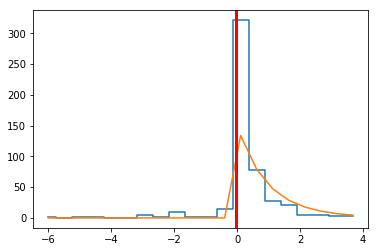

Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: tmp (Potential memory leak).
Warning in <TROOT::Append>: 

In [4]:
#now the question is when is a polynomial too much? 
#To do this we can perform an f-test and use the likelihood output
def fitSigBkgLike(ixsample,iysample,iFix=[0,0,0,0,0]):
    #Signal+Background hypothesis: A guassian + a constant
    b = r.TF1("b","pol5",110,150)
    b.SetParameter(0,iysample[0])
    b.SetParameter(1,0)
    b.SetParameter(2,0)
    b.SetParameter(3,0)
    b.SetParameter(4,0)
    b.SetParameter(5,0)
    if iFix[0]:
        b.FixParameter(1,0)
    if iFix[1]:
        b.FixParameter(2,0)
    if iFix[2]:
        b.FixParameter(3,0)
    if iFix[3]:
        b.FixParameter(4,0)
    if iFix[4]:
        b.FixParameter(5,0)
    #Fill and Fit
    lH=r.TH1F("tmp","tmp",40,110,150)
    for pSample in range(len(ixsample)):
        lH.SetBinContent(pSample+1,iysample[pSample])
    lH.Sumw2()
    lSB=lH.Fit("b","B S L Q")
    return lH,b,lSB.MinFcnValue()

#Lets run a few fits
bs=[]
fbs=[]
likes=[]
iFix=[0,0,0,0,0]
for i0 in range(6):
    if i0 > 0:
        iFix[5-i0]=1
    lH,b5,like = fitSigBkgLike(x,y,iFix)
    fb=[]
    for tmpx in bins:
        val=b5.Eval(tmpx)
        fb.append(val)
    fbs.append(fb)
    bs.append(b5)
    likes.append(like)

#Lets look at the distribution
total=np.sum(y)
print(total)

ntoys=500
#sample from 4th order fit with a 5th order
toylikes=[]
for pTop in range(ntoys):
    toydata=[]
    lH=r.TH1F("tmp","tmp",40,110,150)
    for i0 in range(int(total)):
        pVal = bs[1].GetRandom(110,150)
        lH.Fill(pVal)
    toyxdata=[]
    toyydata=[]
    for i0 in range(lH.GetNbinsX()):
            pX = lH.GetBinCenter(i0+1)
            pY = lH.GetBinContent(i0+1)
            toyxdata.append(pX)
            toyydata.append(pY)
    lH5,b5,like5=fitSigBkgLike(toyxdata,toyydata,[0,0,0,0,0])
    lH4,b4,like4=fitSigBkgLike(toyxdata,toyydata,[0,0,0,1,1])
    #if(abs(like5-like4) > 20):
    if like4 < like5-5:
        print("PROBLEM",like5,like4)
        continue
    toylikes.append((like4-like5)*(40-5.)/like4/(5.-3.))

fig, ax = plt.subplots()
y1, bin_edges = np.histogram(toylikes, bins=20)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers,y1,'-',label='Delta LL',drawstyle = 'steps-mid')
print("likes",likes)

fdist = r.TF1("fDist", "[0]*TMath::FDist(x, [1], [2])", 0,bin_centers[len(bin_centers)-1])
fdist.SetParameter(0,ntoys*0.3)
fdist.SetParameter(1,5-3)
fdist.SetParameter(2,40-5)
for i0 in range(len(bin_centers)):
    if bin_centers[i0] > 0.5:
        pVal=fdist.Eval(bin_centers[i0])
        print(bin_centers[i0],y1[i0],pVal,float(y1[i0])/float(pVal))
        #fdist.SetParameter(0,float(y1[i0])/float(pVal))
        break
fdists=[]
for bin_center in bin_centers:
    pVal=fdist.Eval(bin_center)
    fdists.append(pVal)
plt.plot(bin_centers,fdists,label='f distribution')
ax.axvline(x=(likes[2]-likes[0])/likes[2]*(40.-5)/(5.-3.),linewidth=3,c='r')
plt.show()

In [37]:
#ok so now what we are going to do is compute the significance of the Higgs boson
#We are going to do this with Berstein Polynomials, to do this we will use another tool
x = []
y = []
y_err = []
label='out.txt'
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=' ')
    for row in plots:
        if float(row[1]) > 150 or float(row[1]) < 110:
            continue
        x.append(float(row[1]))
        y.append(float(row[2]))
        #add poisson uncertainties                                                                                                 
        y_err.append(math.sqrt(float(row[2])))

weights = np.linspace(0.,len(y),num=len(y))
for i0 in range(len(y)):
    weights[i0] = float(1./y_err[i0])

def fix(ipol):
    iFix=[0,0,0,0,0]
    for i0 in range(5):
        iFix[i0]=1
    for i0 in range(ipol):
        iFix[i0]=0
    return iFix
        
def ftest(x,y,pol1,pol2):
    #Lets run a few fits
    bs=[]
    likes=[]
    for i0 in range(6):
        lH,b5,like = fitSigBkgLike(x,y,fix(i0))
        bs.append(b5)
        likes.append(like)

    #Lets look at the distribution
    total=np.sum(y)

    #Lets find the right polynomial assuming no signal
    ntoys=500
    #sample from 4th order fit with a 5th order
    toylikes=[]
    for pTop in range(ntoys):
        toydata=[]
        lNBins=40
        lH=r.TH1F("tmp","tmp",lNBins,110,150)
        for i0 in range(int(total)):
            pVal = bs[1].GetRandom(110,150)
            lH.Fill(pVal)
        toyxdata=[]
        toyydata=[]
        for i0 in range(lH.GetNbinsX()):
            pX = lH.GetBinCenter(i0+1)
            pY = lH.GetBinContent(i0+1)
            toyxdata.append(pX)
            toyydata.append(pY)
        lH5,b5,like5=fitSigBkgLike(toyxdata,toyydata,fix(pol1))
        lH4,b4,like4=fitSigBkgLike(toyxdata,toyydata,fix(pol2))
        #if(abs(like5-like4) > 20):
        if like4 < like5-5:
            print("PROBLEM",like5,like4)
            continue
        toylikes.append((like4-like5)*(lNBins-pol1)/like4/(pol1-pol2))

    y1, bin_edges = np.histogram(toylikes, bins=20)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    print("likes",likes)
    
    fdist = r.TF1("fDist", "[0]*TMath::FDist(x, [1], [2])", 0,bin_centers[len(bin_centers)-1])
    fdist.SetParameter(0,ntoys*0.3)
    fdist.SetParameter(1,pol1-pol2)
    fdist.SetParameter(2,lNBins-pol1)
    for i0 in range(len(bin_centers)):
        if bin_centers[i0] > 0.5:
            pVal=fdist.Eval(bin_centers[i0])
            print(bin_centers[i0],y1[i0],pVal,float(y1[i0])/float(pVal))
            break
    fdists=[]
    for bin_center in bin_centers:
        pVal=fdist.Eval(bin_center)
        fdists.append(pVal)
    obs=(likes[pol2]-likes[pol1])/likes[pol2]*(40.-pol1)/(pol1-pol2)
    return bin_centers,fdists,y1,obs

bin_centers,fdists,y1,obs=ftest(x,y,2,3)
fig, ax = plt.subplots()
plt.plot(bin_centers,y1,'-',label='Delta LL',drawstyle = 'steps-mid')
plt.plot(bin_centers,fdists,label='f distribution')
ax.axvline(x=obs,linewidth=3,c='r')
plt.show()

TypeError: void TF1::FixParameter(int ipar, double value) =>
    could not convert argument 2 (a float is required)

Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5) 
Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5])+gaus(x,[6],[7],[8]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5) 


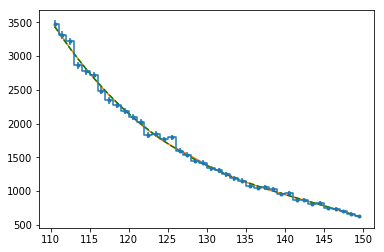

(110.0, 0.04)
(110.5, 1.0)
(111.0, 0.14)
(111.5, 0.98)
(112.0, 0.92)
(112.5, 0.7)
(113.0, 0.48)
(113.5, 0.38)
(114.0, 0.5)
(114.5, 0.82)
(115.0, 0.94)
(115.5, 0.98)
(116.0, 0.98)
(116.5, 0.96)
(117.0, 0.96)
(117.5, 0.98)
(118.0, 0.98)
(118.5, 0.92)
(119.0, 0.88)
(119.5, 0.88)
(120.0, 0.82)
(120.5, 0.54)
(121.0, 0.48)
(121.5, 0.52)
(122.0, 0.0)
(122.5, 0.28)
(123.0, 0.62)
(123.5, 0.9)
(124.0, 0.94)
(124.5, 0.96)
(125.0, 1.0)
(125.5, 0.96)
(126.0, 0.96)
(126.5, 0.94)
(127.0, 0.96)
(127.5, 0.88)
(128.0, 0.52)
(128.5, 0.52)
(129.0, 0.42)
(129.5, 0.2)
(130.0, 0.16)
(130.5, 0.02)
(131.0, 0.08)
(131.5, 0.2)
(132.0, 0.2)
(132.5, 0.3)
(133.0, 0.32)
(133.5, 0.46)
(134.0, 0.54)
(134.5, 0.68)
(135.0, 0.7)
(135.5, 0.7)
(136.0, 0.6)
(136.5, 0.5)
(137.0, 0.26)
(137.5, 0.18)
(138.0, 0.3)
(138.5, 0.42)
(139.0, 0.58)
(139.5, 0.54)
(140.0, 0.38)
(140.5, 0.36)
(141.0, 0.02)
(141.5, 0.24)
(142.0, 0.3)
(142.5, 0.58)
(143.0, 0.66)
(143.5, 0.66)
(144.0, 0.5)
(144.5, 0.46)
(145.0, 0.54)
(145.5, 0.28)
(146.0, 0

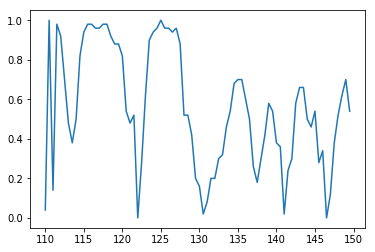

Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5) 
Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5])+gaus(x,[6],[7],[8]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5) 
Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5) 
Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5])+gaus(x,[6],[7],[8]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+[5]*x^5) 
Error in <TFormula::HandlePolN>: Error handling polynomial function - expression is pol5(x,[0],[1],[2],[3],[4],[5]) - trying to replace pol5(0) with ([0]+[1]*x+[2]*x^2+[3]*x^3+[4]*x^4+

In [40]:
#So now we want to perform a hyptohesis test with a signal model 
#To do this we are going to compute the p-value with toys despite our fits looking guassian
def fitSigBkgLike(ixsample,iysample,iMass=125,iFix=[0,0,0,0,0]):
    #Signal+Background hypothesis: A guassian + a constant
    b  = r.TF1("b","pol5(x,[0],[1],[2],[3],[4],[5])",110,150)
    sb = r.TF1("sb","pol5(x,[0],[1],[2],[3],[4],[5])+gaus(x,[6],[7],[8])",110,150)        
    b .SetParameter(0,iysample[0])
    sb.SetParameter(0,iysample[0])
    b .SetParameter(1,0)
    sb.SetParameter(1,0)
    b .SetParameter(2,0)
    sb.SetParameter(2,0)
    b .SetParameter(3,0)
    sb.SetParameter(3,0)
    b .SetParameter(4,0)
    sb.SetParameter(4,0)
    b .SetParameter(5,0)
    sb.SetParameter(5,0)
    if iFix[0]:
        b .FixParameter(1,0)
        sb.FixParameter(1,0)
    if iFix[1]:
        b .FixParameter(2,0)
        sb.FixParameter(2,0)
    if iFix[2]:
        b .FixParameter(3,0)
        sb.FixParameter(3,0)
    if iFix[3]:
        b .FixParameter(4,0)
        sb.FixParameter(4,0)
    if iFix[4]:
        b .FixParameter(5,0)
        sb.FixParameter(5,0)
    #
    sb.SetParameter(6,iysample[0]*0.01)
    sb.FixParameter(7,iMass)
    sb.FixParameter(8,1.9)# 2 GeV detector resolution
    #Fill and Fit
    lH=r.TH1F("tmp","tmp",40,110,150)
    for pSample in range(len(ixsample)):
        lH.SetBinContent(pSample+1,iysample[pSample])
    lH.Sumw2()
    lB=lH.Fit("b","B S L+ Q")
    lSB=lH.Fit("sb","B S L+ Q")
    pVal=-2*(lSB.MinFcnValue()-lB.MinFcnValue())
    yhist,bins,yerr=convertHistToArr(lH)
    return bins,yhist,yerr,sb,b,pVal,sb.GetParameter(6),sb.GetParError(6)

bins,data,dataerr,sb,b,delta,sig,sigerr=fitSigBkgLike(x,y,128,fix(3))
fig, ax = plt.subplots()
fs=[]
fb=[]
for tmpx in bins:
    val=sb.Eval(tmpx)
    fs.append(val)
    val=b.Eval(tmpx)
    fb.append(val)
plt.errorbar(bins,data,yerr=dataerr,marker='.',drawstyle = 'steps-mid')
plt.plot    (bins,fs)
plt.plot    (bins,fb,"g--")
#ax.axvline(x=obs,linewidth=3,c='r')
plt.show()

def significance(x,y,iMass,iFix,ntoys=50):
    bins,data,dataerr,sb,b,pData,sig,sigerr=fitSigBkgLike(x,y,iMass,iFix)
    #return sig/sigerr
    toylikes=[]
    total=np.sum(data)
    pCount=0
    pLL=[]
    for pTop in range(ntoys):
        toydata=[]
        lNBins=40
        lH=r.TH1F("tmp","tmp",lNBins,110,150)
        for i0 in range(int(total)):
            pVal = b.GetRandom(110,150)
            lH.Fill(pVal)
        toyxdata=[]
        toyydata=[]
        for i0 in range(lH.GetNbinsX()):
            pX = lH.GetBinCenter(i0+1)
            pY = lH.GetBinContent(i0+1)
            toyxdata.append(pX)
            toyydata.append(pY)
        bins,data,dataerr,sb,b,pDelta,toysig,toysigerr=fitSigBkgLike(toyxdata,toyydata,iMass,iFix)
        if pData > pDelta:
            pCount = pCount+1
        pLL.append(pDelta)
    return float(pCount)/float(ntoys)#,pLL

#pPval,pLL=significance(x,y,115,fix(3))
#y1, bin_edges = np.histogram(pLL, bins=20)
#bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
#plt.plot(bin_centers,y1,'-',label='Delta LL',drawstyle = 'steps-mid')
masses=[]
sigvals=[]
for mass in np.arange(110,150,0.5): 
    pPval=significance(x,y,mass,fix(3))
    print(mass,pPval)
    masses.append(mass)
    sigvals.append(pPval)
    
fig, ax = plt.subplots()
plt.plot    (masses,sigvals)
plt.show()

In [33]:
np.arange(110,150,0.5)

array([110. , 110.5, 111. , 111.5, 112. , 112.5, 113. , 113.5, 114. ,
       114.5, 115. , 115.5, 116. , 116.5, 117. , 117.5, 118. , 118.5,
       119. , 119.5, 120. , 120.5, 121. , 121.5, 122. , 122.5, 123. ,
       123.5, 124. , 124.5, 125. , 125.5, 126. , 126.5, 127. , 127.5,
       128. , 128.5, 129. , 129.5, 130. , 130.5, 131. , 131.5, 132. ,
       132.5, 133. , 133.5, 134. , 134.5, 135. , 135.5, 136. , 136.5,
       137. , 137.5, 138. , 138.5, 139. , 139.5, 140. , 140.5, 141. ,
       141.5, 142. , 142.5, 143. , 143.5, 144. , 144.5, 145. , 145.5,
       146. , 146.5, 147. , 147.5, 148. , 148.5, 149. , 149.5])